In [12]:
#!pip install scikit-fuzzy -q 

### Tarefa: Elaboração de Short Paper sobre Classificação (Autenticação Bancária) 

Informação dos Atributos:  

Entradas (informações da transformada Wavelet da imagem)  
1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)  

Saída (Classe)  
class (integer): 0 autêntica 1 falsificada

In [13]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
%matplotlib inline

In [2]:
data_types = {
    "wti_variance":"float",
    "wti_skewness":"float",
    "wti_curtosis":"float",
    "image_entropy":"float",
    "class":"int"
}

columns = ["wti_variance", "wti_skewness", "wti_curtosis", "image_entropy","class"]

dataset = pd.read_csv('dados_autent_bancaria.txt',dtype=data_types,names=columns)

In [3]:
dataset.head()

,wti_variance,wti_skewness,wti_curtosis,image_entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


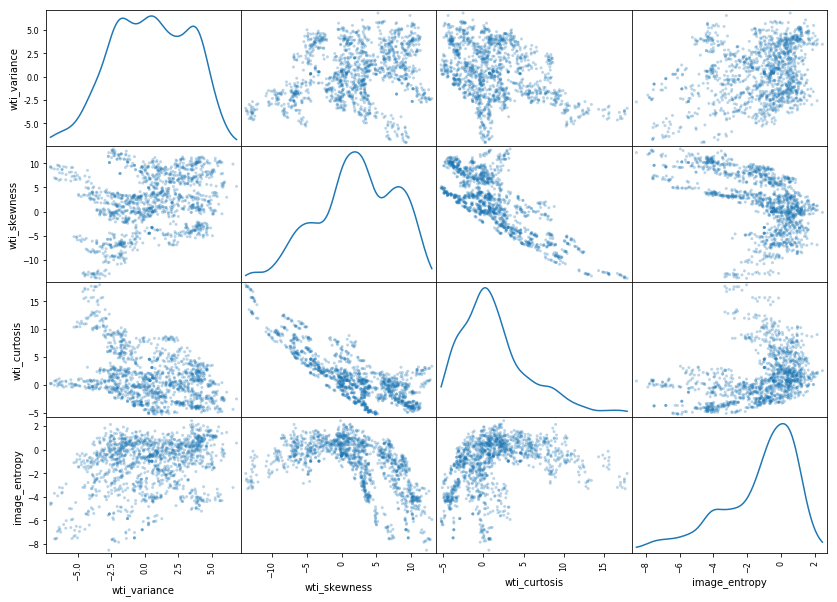

In [4]:
pd.plotting.scatter_matrix(dataset.drop('class',axis=1), alpha = 0.3, figsize = (14,10), diagonal = 'kde');

*Implementar um sistema fuzzy (cujas regras foram definidas pelo
método do Wang Mendel ou pelo especialista).  
Testar diferentes estruturas de sistemas fuzzy (partição do espaço –
formatos e total de conjuntos fuzzy, operadores do mecanismo de
inferência, etc..) 

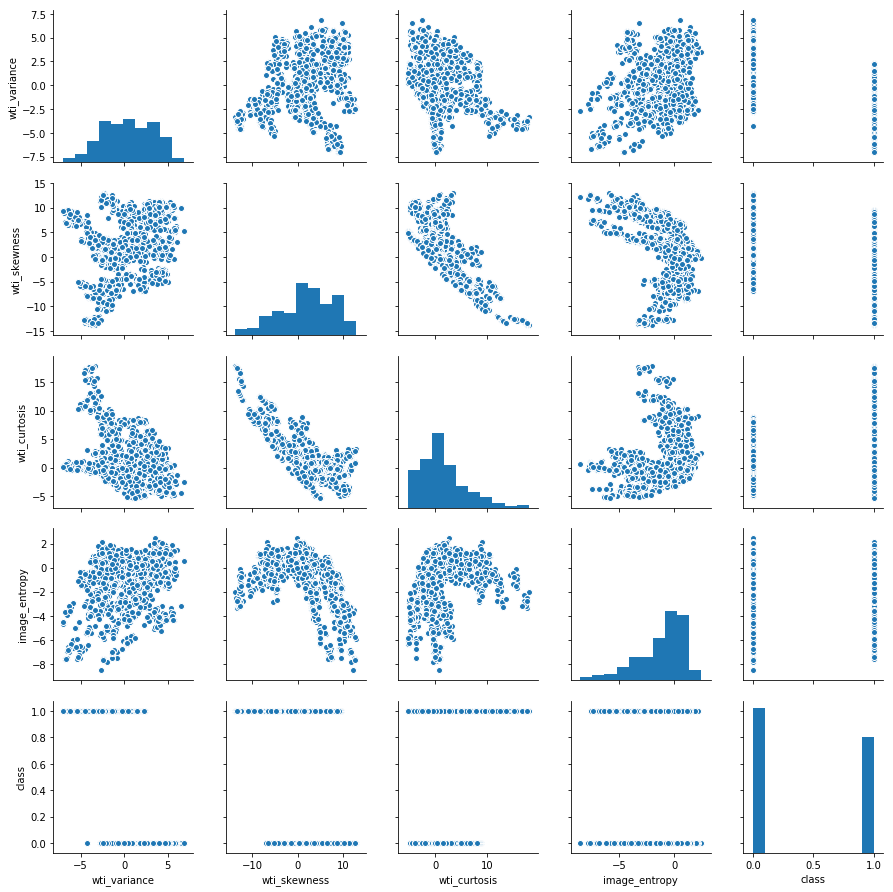

In [7]:
sns.pairplot(dataset)

In [8]:
from sklearn.model_selection import train_test_split

X = dataset.drop('class',axis=1)
y = dataset['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
X_train.head()

,wti_variance,wti_skewness,wti_curtosis,image_entropy
529,-1.38850,12.5026,0.69118,-7.548700
243,2.77440,6.8576,-1.06710,0.075416
1309,-4.28870,-7.8633,11.83870,-1.897800
664,5.35860,3.7557,-1.73450,1.078900
745,0.75736,3.0294,2.91640,-0.068117


In [10]:
X_test.head()

,wti_variance,wti_skewness,wti_curtosis,image_entropy
430,1.569100,6.3465,-0.1828,-2.4099
588,-0.278020,8.1881,-3.1338,-2.5276
296,0.051979,7.0521,-2.0541,-3.1508
184,-1.755900,11.9459,3.0946,-4.8978
244,2.428700,9.3821,-3.2477,-1.4543


#### 2 - Treinamento e otimização de parâmetros de um clusterizador Fuzzy - Fuzzy C-Means (FCM)

In [16]:
fpcs = []
for ncenters in range(2,9):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_train.transpose(), ncenters, 
                                                     m = 2 # exponentiation factor 
                                                     ,error=0.001, maxiter=100, init=None)
    # Store fpc values for later plots
    fpcs.append(fpc)

Text(0,0.5,'Fuzzy partition coefficient')

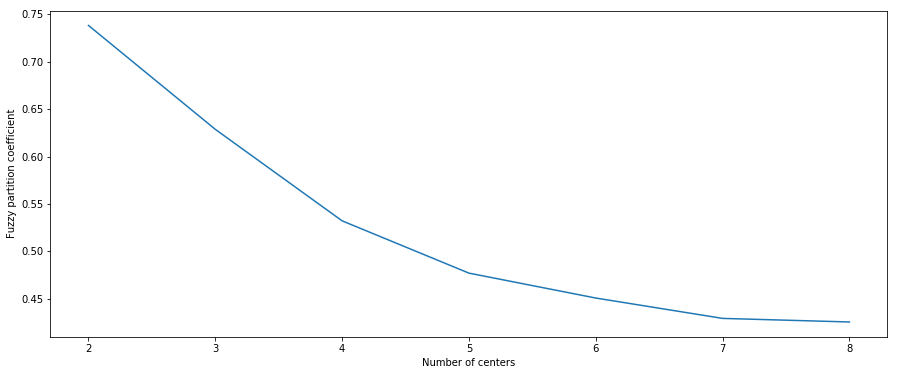

In [17]:
fig1, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(np.r_[2:9], fpcs)
ax1.set_xlabel("Number of centers")
ax1.set_ylabel("Fuzzy partition coefficient")

In [18]:
print("Best Fuzzy partition coefficient: {} com {} clusters.".format(np.max(fpcs),2))

Best Fuzzy partition coefficient: 0.7382163537417694 com 2 clusters.


In [19]:
def findClusters_cmeans(data,nr_clusters):
    ''' Cluster data using fuzzy c-means clustering algorithm '''
    # create the classifier object 
    return fuzz.cluster.cmeans(data, c = nr_clusters, # number of clusters 
                     m = 2 # exponentiation factor 
                     # stopping criteria 
                    ,error=0.001, maxiter=100 )


def predict(data,cntr):
    ''' Predict fuzzy memberships, U, for all points in test_data '''
    # create the classifier object 
    return fuzz.cluster.cmeans_predict(
        data, cntr, m=2, error=0.001, maxiter=100, seed=1234) 

In [20]:
# cluster the data
centroids, u, u0, d, jm, p, fpc = findClusters_cmeans(X_train.transpose(),2)

In [21]:
centroids

array([[-0.3004295 , -4.10606305,  5.49886104, -0.13754575],
       [ 0.97296434,  5.71723373, -1.02762162, -1.96887888]])

In [22]:
labels = [np.argmax(elem) for elem in u.transpose()]

In [23]:
labels[:5]

[1, 1, 0, 1, 1]

In [24]:
fpc

0.7382173973340849

#### 3 - Aplicação da clusterização no conjunto de testes

In [26]:
# predict test data
U, _, _, _, _, fpc  = predict(X_test.transpose(),centroids)

In [27]:
labels = [np.argmax(elem) for elem in U.transpose()]

In [28]:
clusters = pd.Series(labels)
cluster_membership_0 = pd.Series(U[0])
cluster_membership_1 = pd.Series(U[1])

In [29]:
# The fuzzy partition coefficient (FPC)
print("FPC = {}".format(fpc))

FPC = 0.7443467194337205


In [30]:
X_test = X_test.assign(cluster_membership_0=cluster_membership_0.values)
X_test = X_test.assign(cluster_membership_1=cluster_membership_1.values)
X_test = X_test.assign(classe=y_test)
X_test = X_test.assign(cluster=clusters.values)

predicted_dataset = pd.DataFrame(X_test)

In [31]:
predicted_dataset.head(10)

,wti_variance,wti_skewness,wti_curtosis,image_entropy,cluster_membership_0,cluster_membership_1,classe,cluster
430,1.569100,6.34650,-0.1828,-2.409900,0.010929,0.989071,0,1
588,-0.278020,8.18810,-3.1338,-2.527600,0.050936,0.949064,0,1
296,0.051979,7.05210,-2.0541,-3.150800,0.025943,0.974057,0,1
184,-1.755900,11.94590,3.0946,-4.897800,0.199463,0.800537,0,1
244,2.428700,9.38210,-3.2477,-1.454300,0.071938,0.928062,0,1
590,4.635200,-3.00870,2.6773,1.212000,0.762365,0.237635,0,0
78,0.248350,7.64390,0.9885,-0.873710,0.056304,0.943696,0,1
708,5.173100,3.96060,-1.9830,0.407740,0.152793,0.847207,0,1
411,4.004700,0.45937,1.3621,1.618100,0.481917,0.518083,0,1
43,0.964410,5.83950,2.3235,0.066365,0.122096,0.877904,0,1


In [32]:
predicted_dataset[['cluster','classe']].groupby('classe').count()

,cluster
classe,
0,148
1,127


In [33]:
predicted_dataset[['cluster','classe']].groupby('cluster').count()

,classe
cluster,
0,91
1,184


In [35]:
from sklearn.metrics import accuracy_score

predicted_dataset.groupby('classe').count()

predicted_dataset.to_csv("predicted.csv",encoding='utf-8',index=False)
print("Acuracy Score {}".format(accuracy_score(predicted_dataset['classe'],predicted_dataset['cluster'])))

Acuracy Score 0.4218181818181818


In [36]:
pd.crosstab(predicted_dataset['classe'], predicted_dataset['cluster'], rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,40,108,148
1,51,76,127
All,91,184,275


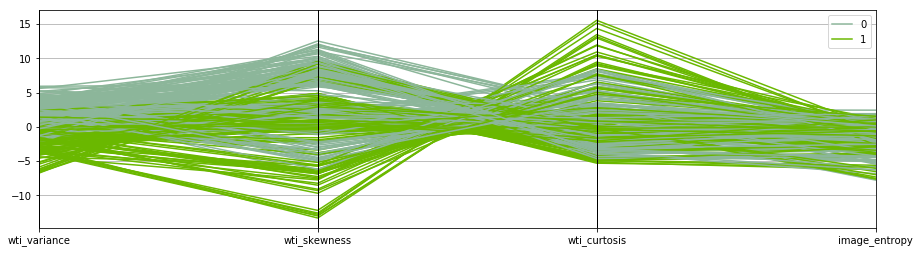

In [37]:
from pandas.plotting import parallel_coordinates
fig1, ax1 = plt.subplots(figsize=(15, 4))

parallel_coordinates(X_test[['wti_variance','wti_skewness','wti_curtosis','image_entropy','classe']], 'classe')
plt.show()

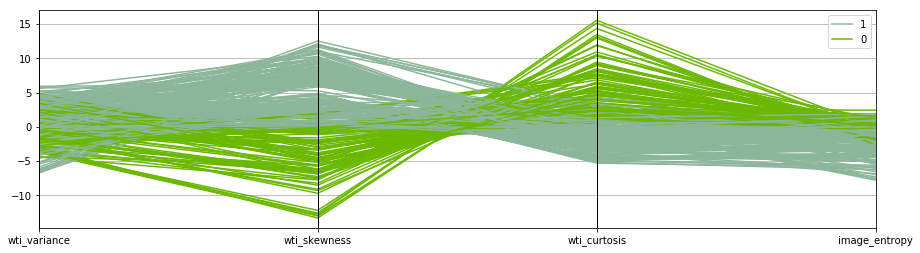

In [38]:
fig1, ax1 = plt.subplots(figsize=(15, 4))
parallel_coordinates(X_test[['wti_variance','wti_skewness','wti_curtosis','image_entropy','cluster']], 'cluster')
plt.show()

https://pythonhosted.org/scikit-fuzzy/overview.html
http://eprints.nottingham.ac.uk/44376/1/toolkit.pdf  
http://www.volksbot.de/surmann/papers/nf2002.pdf  
http://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html#creating-the-tipping-controller-using-the-skfuzzy-control-api